# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [4]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate

## Odds

The following function converts from probabilities to odds.

In [6]:
def odds(p):
    return p / (1-p)

And this function converts from odds to probabilities.

In [7]:
def probability(o):
    return o / (o+1)

If 20% of bettors think my horse will win, that corresponds to odds of 1:4, or 0.25.

In [8]:
p = 0.2
odds(p)

0.25

If the odds against my horse are 1:5, that corresponds to a probability of 1/6.

In [9]:
o = 1/5
probability(o)

0.16666666666666669

We can use the odds form of Bayes's theorem to solve the cookie problem:

In [10]:
prior_odds = 1
likelihood_ratio = 0.75 / 0.5
post_odds = prior_odds * likelihood_ratio
post_odds

1.5

And then we can compute the posterior probability, if desired.

In [11]:
post_prob = probability(post_odds)
post_prob

0.6

If we draw another cookie and it's chocolate, we can do another update:

In [12]:
likelihood_ratio = 0.25 / 0.5
post_odds *= likelihood_ratio
post_odds

0.75

And convert back to probability.

In [13]:
post_prob = probability(post_odds)
post_prob

0.42857142857142855

## Oliver's blood

The likelihood ratio is also useful for talking about the strength of evidence without getting bogged down talking about priors.

As an example, we'll solve this problem from MacKay's {\it Information Theory, Inference, and Learning Algorithms}:

> Two people have left traces of their own blood at the scene of a crime.  A suspect, Oliver, is tested and found to have type 'O' blood.  The blood groups of the two traces are found to be of type 'O' (a common type in the local population, having frequency 60) and of type 'AB' (a rare type, with frequency 1). Do these data [the traces found at the scene] give evidence in favor of the proposition that Oliver was one of the people [who left blood at the scene]?

If Oliver is
one of the people who left blood at the crime scene, then he
accounts for the 'O' sample, so the probability of the data
is just the probability that a random member of the population
has type 'AB' blood, which is 1%.

If Oliver did not leave blood at the scene, then we have two
samples to account for.  If we choose two random people from
the population, what is the chance of finding one with type 'O'
and one with type 'AB'?  Well, there are two ways it might happen:
the first person we choose might have type 'O' and the second
'AB', or the other way around.  So the total probability is
$2 (0.6) (0.01) = 1.2$%.

So the likelihood ratio is:

In [14]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01

likelihood_ratio = like1 / like2
likelihood_ratio

0.8333333333333334

Since the ratio is less than 1, it is evidence *against* the hypothesis that Oliver left blood at the scence.

But it is weak evidence.  For example, if the prior odds were 1 (that is, 50% probability), the posterior odds would be 0.83, which corresponds to a probability of:

In [15]:
post_odds = 1 * like1 / like2
probability(post_odds)

0.45454545454545453

So this evidence doesn't "move the needle" very much.

**Exercise:** Suppose other evidence had made you 90% confident of Oliver's guilt.  How much would this exculpatory evidence change your beliefs?  What if you initially thought there was only a 10% chance of his guilt?

Notice that evidence with the same strength has a different effect on probability, depending on where you started.

In [16]:
# Solution

post_odds = odds(0.9) * like1 / like2
probability(post_odds)

0.8823529411764706

In [17]:
# Solution

post_odds = odds(0.1) * like1 / like2
probability(post_odds)

0.0847457627118644

In [18]:
def make_die(sides):
    hypos = np.arange(1, sides+1)
    return Pmf(1/sides, hypos)

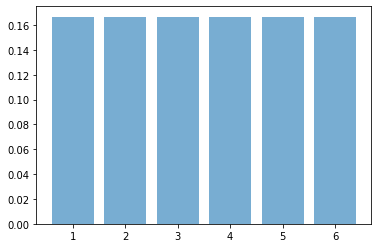

In [55]:
d6 = make_die(6)
d6.bar(alpha=0.6)

In [31]:
def add_dist(pmf1, pmf2):
    """
    """
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res

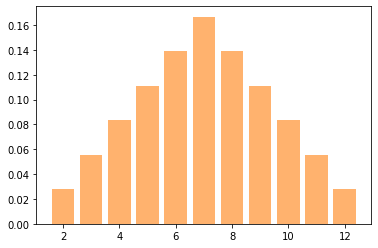

In [56]:
twice = add_dist(d6, d6)
twice.bar(color='C1', alpha=0.6)

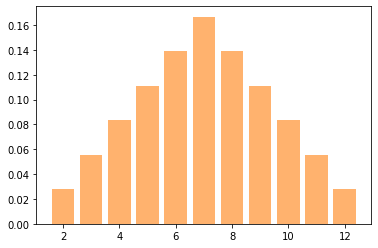

In [57]:
twice = d6.add_dist(d6)
twice.bar(color='C1', alpha=0.6)

In [61]:
def add_dist_seq(seq):
    """Distribution of sum of values from PMFs.
    
    seq: sequence of Pmf objects
    
    returns: Pmf
    """
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

In [66]:
dice = [d6] * 3

In [67]:
def decorate_dice():
    decorate(xlabel='Outcome',
             ylabel='PMF')

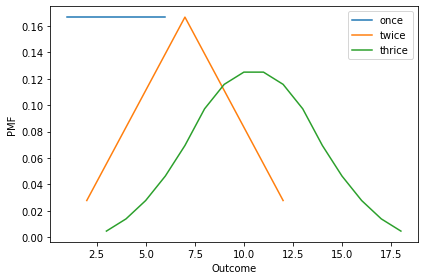

In [68]:
thrice = add_dist_seq(dice)
d6.plot(label='once')
twice.plot(label='twice')
thrice.plot(label='thrice')

decorate_dice()

## Mixture

In [70]:
d4 = make_die(4)

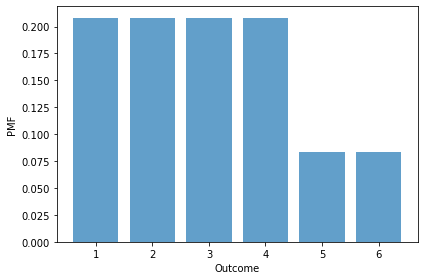

In [81]:
total = d4.add(d6, fill_value=0)
mix = Pmf(total)
mix.normalize()
mix.bar(alpha=0.7)
decorate_dice()

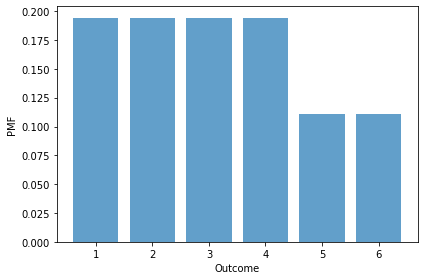

In [85]:
total = d4.add(2*d6, fill_value=0)
mix = Pmf(total)
mix.normalize()
mix.bar(alpha=0.7)
decorate_dice()

In [98]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


In [99]:
dice = [make_die(sides) for sides in hypos]

In [100]:
product = pmf_dice * dice
product[4]

1    0.041667
2    0.041667
3    0.041667
4    0.041667
dtype: float64

In [101]:
def add_pmf_seq(seq):
    """Add up a sequence of PMFs.
    
    seq: sequence of Pmf
    
    returns: Pmf
    """
    total = seq[0]
    for other in seq[1:]:
        total = total.add(other, fill_value=0)
    return Pmf(total)

In [102]:
add_pmf_seq(product.values)

,probs
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.062500
8,0.062500


In [103]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions.
    
    pmf: mapping from each hypothesis to its probability
    pmf_seq: sequence of Pmfs, each representing 
             a conditional distribution
    """
    product = pmf * pmf_seq
    return add_pmf_seq(product.values)

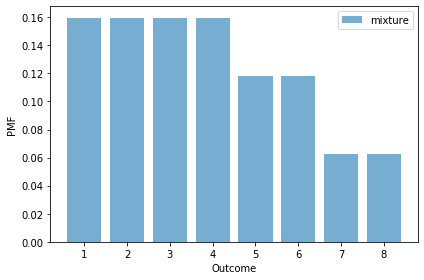

In [108]:
mix = make_mixture(pmf_dice, dice)
mix.bar(label='mixture', alpha=0.6)
decorate_dice()

In [107]:
mix.sum()

1.0

## Maximum

In [43]:
def pmf_max(pmf1, pmf2):
    """Computes the distribution of the max of values 
    drawn from two Pmfs.

    pmf1, pmf2: Pmf objects

    returns: new Pmf
    """
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = max(q1, q2)
            p = p1 * p2
            res[q] = res(q) + p
    return res
    

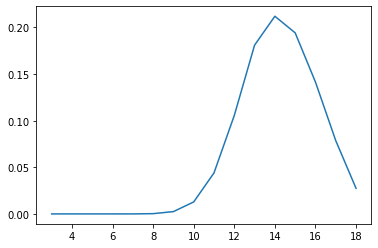

In [44]:
# compute the distribution of the best attribute the hard way
best_attr2 = pmf_max(three_exact, three_exact)
best_attr4 = pmf_max(best_attr2, best_attr2)
best_attr6 = pmf_max(best_attr4, best_attr2)
best_attr6.plot()

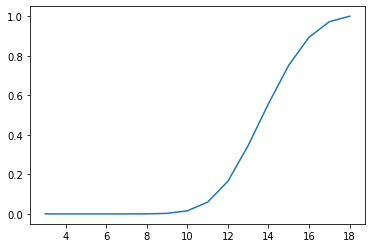

In [50]:
from empiricaldist import Cdf

attr_cdf = three_exact.make_cdf()
best_attr_cdf = Cdf(attr_cdf**6)

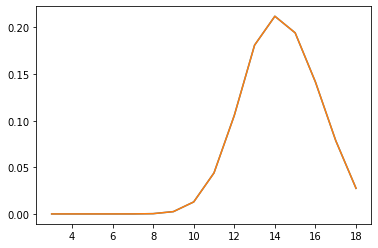

In [51]:
best_attr_cdf.make_pmf().plot()
best_attr6.plot()
